In [20]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
dataset = 'ASSISTments_12-13'
inter_df = pd.read_csv('{}/interactions.csv'.format(dataset), sep='\t')
with open('{}/skill_name.json'.format(dataset)) as fp:
    skill2name = json.load(fp)

### 1. Counstruct data with only top-10 frequency skills

In [22]:
top_skills = list(inter_df['skill_id'].value_counts()[:10].index)
for s in top_skills:
    print(skill2name[str(s)])

Equation Solving Two or Fewer Steps
Addition and Subtraction Integers
Addition and Subtraction Fractions
Conversion of Fraction Decimals Percents
Multiplication and Division Integers
Multiplication and Division Positive Decimals
Order of Operations All
Multiplication Fractions
Division Fractions
Equation Solving More Than Two Steps


In [23]:
top_inter_df = inter_df.copy()[inter_df['skill_id'].isin(top_skills)]
new_skill_id = range(len(top_skills))
skill_map = dict(zip(top_skills, new_skill_id))
top_inter_df['skill_id'] = top_inter_df['skill_id'].apply(lambda x: skill_map[x])  # re-index to 0-9
top_inter_df.head()

,teacher_id,first_action,problem_type,timestamp,problem_id,dwell_time,tutor_mode,original,user_id,school_id,skill_id,correct
1,0,0,1,1.371614e+09,1,24.0,0,0,0,0,0,1.0
8,1,0,1,1.347427e+09,8,68.0,0,0,1,1,6,1.0
19,1,0,1,1.348406e+09,19,179.0,0,0,1,1,5,0.0
20,1,0,1,1.348406e+09,20,84.0,0,0,1,1,5,1.0
21,1,0,1,1.348406e+09,21,37.0,0,0,1,1,5,1.0


In [27]:
# new_skill2name = dict()
# for i, s in enumerate(top_skills):
#     new_skill2name[i] = skill2name[str(s)]
# top_inter_df.to_csv('{}_Core-10/interactions.csv'.format(dataset), sep='\t')
with open('{}_Core-10/skill_name.json'.format(dataset), 'w') as fp:
    json.dump(new_skill2name, fp)

In [26]:
new_skill2name

{0: 'Equation Solving Two or Fewer Steps',
 1: 'Addition and Subtraction Integers',
 2: 'Addition and Subtraction Fractions',
 3: 'Conversion of Fraction Decimals Percents',
 4: 'Multiplication and Division Integers',
 5: 'Multiplication and Division Positive Decimals',
 6: 'Order of Operations All',
 7: 'Multiplication Fractions',
 8: 'Division Fractions',
 9: 'Equation Solving More Than Two Steps'}

### 2. Observe correct probability

In [10]:
max_skill = top_inter_df['skill_id'].max() + 1
correct_prob = np.zeros(max_skill)
skill_total = np.zeros(max_skill)
for skill, correct in zip(top_inter_df['skill_id'], top_inter_df['correct']):
    skill_total[skill] += 1
    if correct == 1:
        correct_prob[skill] += 1
correct_prob /= skill_total
correct_prob

array([0.71922484, 0.72176192, 0.6840936 , 0.75080673, 0.84809766,
       0.73032205, 0.62357341, 0.68229845, 0.67369061, 0.58199735])

### 3. Conditional Mutual Information (CMI) analyses

In [11]:
# Count the number of appearance in user sequence for all the circumustances: 
# (pre-skill, post-skill, time-interval, pre-correctness, post-correctness)
# SLOW!

max_time_bin = 20
cross_effects = np.zeros((max_skill, max_skill, max_time_bin, 2, 2))
for user, user_df in top_inter_df.groupby('user_id'):
    skills = user_df['skill_id'].values
    corrects = user_df['correct'].values.astype(int)
    times = user_df['timestamp'].values
    for i in range(len(skills) - 1):
        for j in range(i + 1, len(skills)):
            time = np.maximum(times[j] - times[i], 1e-6)
            time_bin = int(np.maximum(np.log2(time), 0))  # log transformation
            time_bin = np.minimum(time_bin, max_time_bin - 1)  # truncate
            cross_effects[skills[i]][skills[j]][time_bin][corrects[i]][corrects[j]] += 1

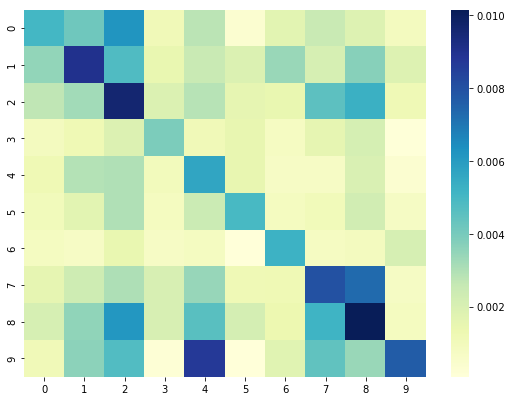

In [12]:
# cross-effects

mutual_info = np.zeros((max_skill, max_skill))
total = cross_effects.sum(-1).sum(-1).sum(-1)
for a_i in [0, 1]:
    for a_j in [0, 1]:
        joint = cross_effects[:, :, :, a_i, a_j].sum(-1) / total
        x = cross_effects[:, :, :, a_i, :].sum(-1).sum(-1) / total
        y = cross_effects[:, :, :, :, a_j].sum(-1).sum(-1) / total
        mutual_info += joint * np.log(joint / (x + 1e-6) / (y + 1e-6) + 1e-6)

plt.figure(figsize=(9, 6.75))
sns.heatmap(mutual_info, cmap="YlGnBu")
plt.savefig('../plot/cross_effects.png', dpi=600)

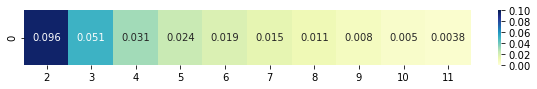

In [13]:
# global temporal cross-effects

mutual_info = np.zeros(max_time_bin)
global_effect = cross_effects.sum(0).sum(0)
total = global_effect.sum(-1).sum(-1)
for a_i in [0, 1]:
    for a_j in [0, 1]:
        joint = global_effect[:, a_i, a_j] / total
        x = global_effect[:, a_i, :].sum(-1) / total
        y = global_effect[:, :, a_j].sum(-1) / total
        mutual_info += joint * np.log(joint / (x + 1e-6) / (y + 1e-6) + 1e-6)
        
plt.figure(figsize=(10,1))
sns.heatmap(np.expand_dims(mutual_info[2:12], 0), cmap="YlGnBu", annot=True,
            vmin=0, vmax=0.1, xticklabels=range(2, 12))
plt.savefig('../plot/global_temporal.png', dpi=600)

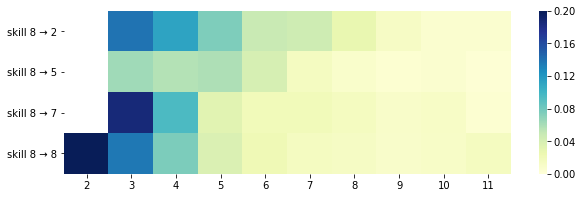

In [14]:
# temporal cross-effects

target_skill = 8
mutual_info = np.zeros((max_skill, max_time_bin))
total = cross_effects[target_skill, :, :, :, :].sum(-1).sum(-1)
for a_i in [0, 1]:
    for a_j in [0, 1]:
        joint = cross_effects[target_skill, :, :, a_i, a_j]
        x = cross_effects[target_skill, :, :, a_i, :].sum(-1)
        y = cross_effects[target_skill, :, :, :, a_j].sum(-1)
        mutual_info += joint * np.log(joint * total / (x + 1e-6) / (y + 1e-6) + 1e-6) / (total + 1e-6)

plt.figure(figsize=(10, 3))
selected_skills = np.array([2, 5, 7, 8])
yticks = ['skill 8 → ' + str(x) for x in selected_skills]
ax = sns.heatmap(mutual_info[selected_skills, 2:12], cmap="YlGnBu", mask=(total[selected_skills, 2:12] < 50), 
                 annot=False, vmin=0, vmax=0.2, xticklabels=range(2, 12), yticklabels=yticks)
plt.savefig('../plot/temporal_cross.png', dpi=600)
plt.show()